In [ ]:
import torchvision.models as models
from torchsummary import summary
import torch.nn as nn
import torch
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import json
import numpy as np
import os
import torch.optim as optim
import imageio
import torchvision.models as models
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Objective:
Create a resuable model development pipeline than can make audio classification way more streamlined.

It would do these things:
* Train the model
* Validate the model
* Test the model
* Summarize and report results

# Setup

Establish GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Establish dataset structure

In [ ]:
# custom 2D spectrogram dataset class
class SpectrogramDataset2D(torch.utils.data.Dataset):
    def __init__(self, data_dir, mode, labels_json, is_aug=False):
        self.is_aug = is_aug
        self.data_dir = data_dir
        self.mode = mode
        self.labels_json = labels_json
        if self.is_aug:
          self.image_filenames = [spectrogram_file for spectrogram_file in os.listdir(self.data_dir)]
        else:
          self.image_filenames = [spectrogram_file for spectrogram_file in os.listdir(os.path.join(self.data_dir, self.mode))]
        self.pcg_ids = [self.pcgid_from_filename(image_filename) for image_filename in self.image_filenames]
        #self.labels = torch.tensor(self.load_data()).unsqueeze(1).float()
        self.labels = torch.tensor(self.load_data()).float()

    def __getitem__(self, index):
        # locate png file and extract image as 2d array
        pcg_id = self.pcgid_from_filename(self.image_filenames[index])
        if self.is_aug:
          spect_path = self.data_dir + str(pcg_id) + ".png"
        else:
          spect_path = self.data_dir + self.mode + '/' + str(pcg_id) + ".png"
        img_data = imageio.imread(spect_path)
        image_tensor = torch.tensor(img_data).unsqueeze(0)

        label = self.labels[index]
        return image_tensor, label

    def __len__(self):
        return len(self.image_filenames)

    def pcgid_from_filename(self, filename):
        return filename[:-4] # removes .wav extension

    def labels_from_json(self, labels_json):
        labels_df = pd.read_csv(self.labels_json)[['pcg_id','murmur']]
        labels_dict = dict(zip(labels_df.pcg_id, labels_df.murmur))
        labels = []
        label_key = {"Absent": 0,
                     "Present": 1,
                     "Unknown": 2,
                     "0": 0,
                     "1": 1,
                     "2": 2}
        for image_filename in self.image_filenames:
            pcg_id = self.pcgid_from_filename(image_filename)
            label_str = labels_dict[pcg_id]
            labels.append(label_key[label_str])
        return labels

    def load_data(self):
        # list of labels
        labels = self.labels_from_json(self.labels_json)

        # list of image filenames
        labels = self.labels_from_json(self.labels_json)  # list of corresponding labels
        return labels

# Model Creation

In [ ]:
# locating data directories
real_spec_data_dir = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/real/spectrograms/"
real_wav_data_dir =  "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/real/phonocardiograms/"
ai_spec_data_dir =   "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/ai/spectrograms/"
ai_wav_data_dir =    "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/ai/phonocardiograms/"

In [ ]:
# augmented data directories
#aug_spec_data_dir = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/augmented/spectrograms/smart_aug_50p/"
#aug_spec_data_dir = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/augmented/spectrograms/smart_aug_694/"
aug_spec_data_dir = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/augmented/spectrograms/rand_aug_1041/"

In [ ]:
# locating labels directory
real_labels_json_path = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/model_development/real_murmur_key.csv"
ai_labels_json_path = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/model_development/ai_murmur_key.csv"
aug_labels_json_path = "/content/drive/MyDrive/Stuff I Coded/PCG_synthesis/data2/augmented/rand_aug_1041_key.csv"

In [ ]:
# defining the dataset and dataloaders
train_dataset = SpectrogramDataset2D(ai_spec_data_dir, 'train', ai_labels_json_path)
#train_dataset = SpectrogramDataset2D(aug_spec_data_dir, 'train', aug_labels_json_path, is_aug=True)
#train_dataset = SpectrogramDataset2D(real_spec_data_dir, 'train', real_labels_json_path)

val_dataset = SpectrogramDataset2D(real_spec_data_dir, 'val', real_labels_json_path)
test_dataset = SpectrogramDataset2D(real_spec_data_dir, 'test', real_labels_json_path)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [ ]:
# adjusting the first convolutional layer to accept single-channel input
# (1, 128, 385) instead of the original (3, 224, 224)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# adjusting the final layer to output probabilities for multiclass classification
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 3),
    nn.Softmax()
)

# making a custom ResNet18 class
class CustomResNet18(nn.Module):
    def __init__(self):
        super(CustomResNet18, self).__init__()
        self.model = resnet18

    def forward(self, x):
        return self.model(x)

# Instantiate the custom model
my_resnet18 = CustomResNet18()

In [ ]:
my_resnet18.to(device);

# Training Setup

In [ ]:
model = resnet18

In [ ]:
# loss function and optimizer
criterion = nn.functional.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
if torch.cuda.is_available():
    model.cuda()

In [ ]:
train_dataset.__getitem__(0)

<ipython-input-12-e8f373e4609a>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data = imageio.imread(spect_path)


(tensor([[[ 38,  19,   0,  ...,   0,   0,   0],
          [ 38,  19,   0,  ...,   0,   0,   0],
          [ 38,  19,   0,  ...,   0,   0,   0],
          ...,
          [199, 194, 162,  ..., 171, 155, 134],
          [212, 210, 185,  ..., 172, 160, 146],
          [208, 206, 168,  ..., 173, 178, 165]]], dtype=torch.uint8),
 tensor(0.))


# Train Model

In [ ]:
SEED = 3141

# setting seeds for reproducibility
torch.manual_seed(SEED) # PyTorch random seed
np.random.seed(SEED) # Numpy random seed
random.seed(SEED) # Python random seed

# If you are working with CUDA...
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # if you are using multi-GPU.
    # Below two lines for deterministic algorithm, might slow down your training.
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

In [ ]:
# training loop
batch_losses = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):

      data = data.to(device, dtype=torch.float)
      target = target.type(torch.LongTensor).squeeze()
      target = target.to(device)

      optimizer.zero_grad()
      output = model(data)

      loss = criterion(output, target)
      batch_losses.append(loss)
      loss.backward()
      optimizer.step()

      if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_dataloader.dataset),
              100. * batch_idx / len(train_dataloader), loss.item()))

<ipython-input-12-e8f373e4609a>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data = imageio.imread(spect_path)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch: 0 [0/2101 (0%)]	Loss: 1.048990
Train Epoch: 0 [640/2101 (30%)]	Loss: 0.990977
Train Epoch: 0 [1280/2101 (61%)]	Loss: 0.976369
Train Epoch: 0 [1920/2101 (91%)]	Loss: 0.883777
Train Epoch: 1 [0/2101 (0%)]	Loss: 0.863470
Train Epoch: 1 [640/2101 (30%)]	Loss: 0.798746
Train Epoch: 1 [1280/2101 (61%)]	Loss: 0.828792
Train Epoch: 1 [1920/2101 (91%)]	Loss: 0.767235
Train Epoch: 2 [0/2101 (0%)]	Loss: 0.787060
Train Epoch: 2 [640/2101 (30%)]	Loss: 0.717883
Train Epoch: 2 [1280/2101 (61%)]	Loss: 0.725649
Train Epoch: 2 [1920/2101 (91%)]	Loss: 0.661937
Train Epoch: 3 [0/2101 (0%)]	Loss: 0.668685
Train Epoch: 3 [640/2101 (30%)]	Loss: 0.670293
Train Epoch: 3 [1280/2101 (61%)]	Loss: 0.628877
Train Epoch: 3 [1920/2101 (91%)]	Loss: 0.661812
Train Epoch: 4 [0/2101 (0%)]	Loss: 0.682220
Train Epoch: 4 [640/2101 (30%)]	Loss: 0.622401
Train Epoch: 4 [1280/2101 (61%)]	Loss: 0.594941
Train Epoch: 4 [1920/2101 (91%)]	Loss: 0.605135
Train Epoch: 5 [0/2101 (0%)]	Loss: 0.611842
Train Epoch: 5 [640/2

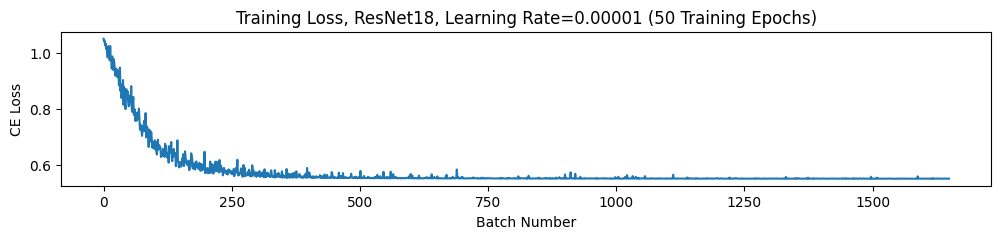

In [ ]:
plt.figure(figsize=[12,2])
plt.title("Training Loss, ResNet18, Learning Rate=0.00001 (50 Training Epochs)");
plt.ylabel("CE Loss");
plt.xlabel("Batch Number");
batch_losses_cpu = torch.tensor(batch_losses).cpu().numpy()
plt.plot(batch_losses_cpu);

# Test Model

In [ ]:
model.eval()

correct = 0
total = 0
y_true = []
y_pred = []

# No need to track gradients for validation, hence torch.no_grad()
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.type(torch.LongTensor).squeeze()
        labels = labels.to(device)
        # Forward pass to get outputs
        outputs = model(inputs)

        # The class with the highest value is our predicted class
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true += labels.tolist()
        y_pred += predicted.tolist()

accuracy = correct / total
# print(f'Accuracy of the network on the test images: {accuracy * 100:.2f}%')
print(f'Accuracy of the network on the test images: {accuracy}')

recalls = recall_score(y_true, y_pred, labels=[0, 1, 2], average=None)
precisions = precision_score(y_true, y_pred, labels=[0, 1, 2], average=None)

print("Recall for class 0:", recalls[0])
print("Recall for class 1:", recalls[1])
print("Recall for class 2:", recalls[2])

print("Precision for class 0:", precisions[0])
print("Precision for class 1:", precisions[1])
print("Precision for class 2:", precisions[2])


<ipython-input-12-e8f373e4609a>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data = imageio.imread(spect_path)


tensor([0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0,
        0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0,
        0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0], device='cuda:0')
tensor([2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
        0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,